<a href="https://colab.research.google.com/github/mirovoy465/colab/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22hw07_trees_rf_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1) -->
<img src="https://github.com/hse-ds/iad-intro-ds/blob/master/2023/homeworks/hw07-trees/meme.jpg?raw=1" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
k1 = 8
k2 = 2

def entropy(k):
  return round(-k * np.log2(k), 2)

en = entropy(k1 / (k1 + k2)) + entropy(k2/ (k1 + k2))
en

0.72

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
def gini(p):
  _, counts = np.unique(p, return_counts = True)
  pk = counts / len(p)
  return np.sum(pk * (1 - pk))

def log_entropy(p):
  _, counts = np.unique(p, return_counts = True)
  pk = counts / len(p)
  return -np.sum(pk * np.log(pk))

def criterion(left, right, entropy_func):
  m = np.append(left, right)
  return entropy_func(m) - len(left) / len(m) * entropy_func(left) - len(right) / len(m) * entropy_func(right)


left = np.ones(8)
right = np.ones(2)

criterion(left, right, gini)


0.0

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
y =  [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]


pred = np.average(y)
pred

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
from statistics import mode
from collections import Counter
from typing import Dict, List, Tuple, Union
import numpy as np
import pandas as pd

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  length == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def std_sqr(data):
      return np.std(data) ** 2

    def gini(data):
      _, counts = np.unique(data, return_counts = True)
      pk = counts / len(data)
      return np.sum(pk * (1 - pk))

    if task == "classification":
      entropy_func = gini
    elif task == "regression":
      entropy_left = std_sqr
    else: raise ValueError()

    data = pd.DataFrame(target_vector, columns = ['target'])
    data['feat_name'] = feature_vector
    data = data.sort_values('feat_name', ignore_index=True)

    ginis = []

    thresholds = (data['feat_name'].values[1:] + data['feat_name'].values[:-1]) / 2

    for i in range(1, len(thresholds)+1):

      entropy_left = (i / data.shape[0]) * entropy_func(data.target[:i])
      entropy_right = (1 - i / data.shape[0]) * entropy_func(data.target[i:])

      ginis.append(entropy_left + entropy_right)

    gini_best = np.nanmin(ginis)
    threshold_best = thresholds[np.nanargmin(ginis)]

    return thresholds, ginis, threshold_best, gini_best

In [ ]:
import matplotlib.pyplot as plt
X = np.arange(40).reshape(20,2)
# np.random.seed(20)
y = np.random.normal(size=20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
tree_test = DecisionTree(task='regression').fit(X_train, y_train)
tree_test

NameError: ignored

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(thresholds,ginis)
print(gini_best,threshold_best)

Эту функцию можно протестировать на датасете `California`.

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
X['target'] = data["target"]

In [ ]:
threshholds, ginis, threshhold_best, gini_best = find_best_split(X['MedInc'], X['target'], task = 'regression')

In [ ]:
print(threshhold_best, gini_best)

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(sorted(X['MedInc']), np.append(np.std(ginis),ginis))

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!head -n5 students.csv

,STG,SCG,STR,LPR,PEG,UNS
0,0.0,0.0,0.0,0.0,0.0,0
1,0.08,0.08,0.1,0.24,0.9,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.1,0.1,0.15,0.65,0.3,1


In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  length == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    def std_sqr(data):
      return np.std(data) ** 2

    def gini(data):
      _, counts = np.unique(data, return_counts = True)
      pk = counts / len(data)
      return np.sum(pk * (1 - pk))

    if task == "classification":
      entropy_func = gini
    elif task == "regression":
      entropy_left = std_sqr
    else: raise ValueError()

    data = pd.DataFrame(target_vector, columns = ['target'])
    data['feat'] = feature_vector
    data = data.sort_values('feat', ignore_index=True)

    ginis = []

    thresholds = (data['feat'].values[1:] + data['feat'].values[:-1]) / 2

    for i in range(1, len(thresholds)+1):

      entropy_left = (i / data.shape[0]) * entropy_func(data.target[:i])
      entropy_right = (1 - i / data.shape[0]) * entropy_func(data.target[i:])

      ginis.append(entropy_left + entropy_right)

    gini_best = np.nanmin(ginis)
    threshold_best = thresholds[np.nanargmin(ginis)]

    return thresholds, ginis, threshold_best, gini_best

In [ ]:
class DecisionTree:

    def __init__(
        self,
        task: str = "classification"
    ) -> None:
        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # гиперпараметры дерева
        self.task = task

    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        print(sub_y.shape)
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["ans"] = sub_y[0]
            print('ans reached',sub_y.mean())
            return self

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            # подготавливаем признак для поиска оптимального порога
            feature_vector = sub_X[:,feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task)

            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini
                threshold_best = threshold
                # split - маска на объекты, которые должны попасть в левое поддерево
                split = feature_vector < threshold_best
        #     print(gini_best, feature)
        # print(sub_X)
        # print('best:', threshold_best, gini_best, feature_best)
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            if self.task == "classification":
              node["ans"] = Counter(sub_y).most_common(1)[0][0]
            elif self.task == "regression":
              node["ans"] = np.mean(sub_y)
            else: raise ValueError()
            # print('ans reached',sub_y.mean())
            return self

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        node["threshold"] = threshold_best

        node["left_child"], node["right_child"] = {}, {}

        # print(f'left of {sub_y.shape}')
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        # print(f'right of {sub_y.shape}')
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
          ans = node['ans']
          return ans
        else:
          for i in range(x.shape[0]):
            if i == node["feature_split"]:
              if x[i] < node['threshold']:
                ans = self._predict_node(x, node["left_child"])
              else:
                ans = self._predict_node(x, node["right_child"])
        return ans

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # return self._predict_node(X, self._tree)

        if X[0].shape:
          predicted = []
          for x in X:
              predicted.append(self._predict_node(x, self._tree))
        else:
          predicted = self._predict_node(X, self._tree)
        return predicted

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
y_train[0]

0

In [ ]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('students.csv')
data = data.drop(data.columns[0], axis = 1)
X = data.drop('UNS', axis = 1)
y = data['UNS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

tree = DecisionTree().fit(X_train.values, y_train.values)

np.mean([tree.predict(X_test.values), y_test.values])
[tree.predict(X_test.values), y_test.values]

(180,)
(77,)
(67,)
(15,)
(12,)
ans reached 0.0
(3,)
(2,)
ans reached 0.0
(1,)
ans reached 1.0
(52,)
(3,)
(2,)
ans reached 0.0
(1,)
ans reached 1.0
(49,)
ans reached 0.0
(10,)
(5,)
ans reached 0.0
(5,)
ans reached 1.0
(103,)
(5,)
(2,)
ans reached 0.0
(3,)
ans reached 1.0
(98,)
ans reached 1.0


[[0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  1],
 array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1])]

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Data

/content/drive/MyDrive/Data


In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

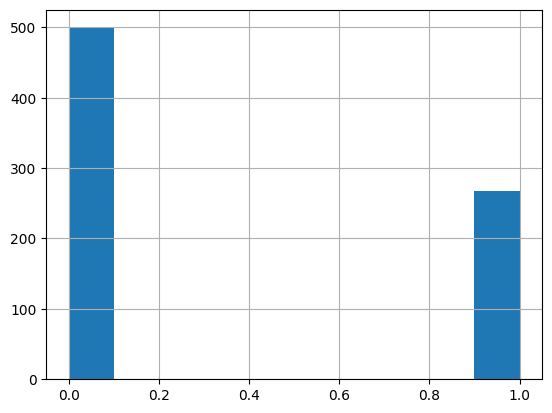

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
y = data['Outcome']
X = data.drop('Outcome', axis = 1 )
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)
sampler = RandomOverSampler(random_state = 42)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, random_state = 42, test_size = 0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

0.8170212765957447 25 3 7


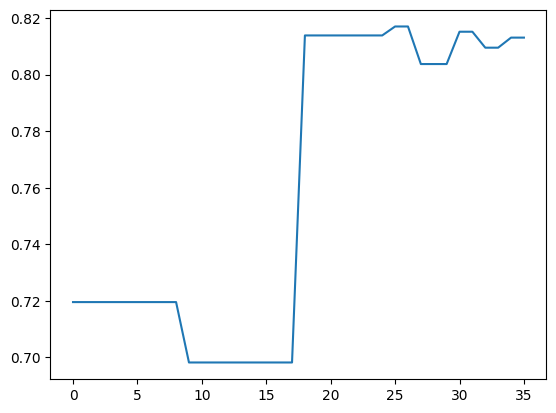

In [ ]:
depths = [x for x in range(1,5)]
min_leafs = [x for x in range(1,10)]

fits = []
for depth in depths:
  for leaf in min_leafs:
    fit = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf).fit(X_train, y_train)
    fits.append(fit)
f1s = []
for fit in fits:
  f1s.append(f1_score(y_val, fit.predict(X_val)))

plt.plot(f1s)
best_depth = round(np.argmax(f1s) / len(min_leafs))
best_leaf = np.argmax(f1s) - len(min_leafs) * (best_depth - 1)
print(np.max(f1s), np.argmax(f1s), best_depth, best_leaf)

In [ ]:
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = pd.concat([y_train, y_val], axis = 0)
tree_cv = DecisionTreeClassifier(max_depth = best_depth, min_samples_leaf = best_leaf)
tree = DecisionTreeClassifier()
fit_cv = tree_cv.fit(X_train, y_train)
fit = tree.fit(X_train, y_train)

In [ ]:
print(f1_score(y_test, fit_cv.predict(X_test)))
print(f1_score(y_test, fit_cv.predict(X_test)))

0.6232558139534884
0.6232558139534884


In [ ]:
roc_auc_score(y_test, fit_cv.predict(X_test))

0.6935844370860926

In [ ]:
print(classification_report(y_test, fit_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.55      0.67       151
           1       0.50      0.84      0.62        80

    accuracy                           0.65       231
   macro avg       0.68      0.69      0.65       231
weighted avg       0.74      0.65      0.66       231



**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(estimator = DecisionTreeClassifier(), max_samples = 0.66, n_estimators = 50)
fit_bag = bagging.fit(X_train, y_train)

In [ ]:
f1_score(y_test, fit_bag.predict(X_test))

0.6551724137931034

In [ ]:
roc_auc_score(y_test, fit_bag.predict(X_test))

0.7337334437086093

In [ ]:
print(classification_report(y_test, fit_bag.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       151
           1       0.61      0.71      0.66        80

    accuracy                           0.74       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.74      0.74       231



**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

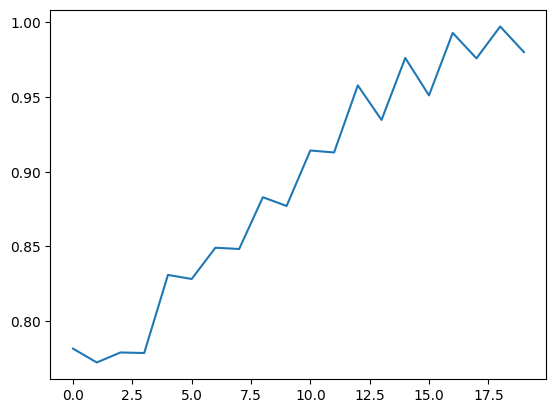

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
start_depth = 1
start_leaf = 1
depths = [x for x in range(1,11)]
min_leafs = [x for x in range(start_leaf,3)]

f1s = []
for depth in depths:
  for leaf in min_leafs:
    fit = RFC(50, max_depth = depth, min_samples_leaf = leaf).fit(X_train, y_train)
    f1s.append((depth, leaf, f1_score(y_train, fit.predict(X_train))))


plt.plot([x[2] for x in f1s])

In [ ]:
f1s

[(1, 1, 0.7816711590296497),
 (1, 2, 0.7724137931034483),
 (2, 1, 0.7791044776119402),
 (2, 2, 0.778735632183908),
 (3, 1, 0.8309859154929579),
 (3, 2, 0.8282548476454293),
 (4, 1, 0.8491620111731845),
 (4, 2, 0.8483146067415731),
 (5, 1, 0.8829337094499294),
 (5, 2, 0.8770949720670391),
 (6, 1, 0.9142053445850914),
 (6, 2, 0.9128630705394192),
 (7, 1, 0.9577464788732394),
 (7, 2, 0.9346314325452018),
 (8, 1, 0.9760900140646976),
 (8, 2, 0.9510489510489512),
 (9, 1, 0.9928469241773962),
 (9, 2, 0.9758179231863443),
 (10, 1, 0.9971428571428572),
 (10, 2, 0.9800000000000001)]

In [ ]:
best_fit = RFC(50, max_depth = best_depth, min_samples_leaf = best_leaf).fit(X_train, y_train)
print(f1_score(y_test, best_fit.predict(X_test)))
print(roc_auc_score(y_test, best_fit.predict(X_test)))
print(classification_report(y_test, best_fit.predict(X_test)))

0.6521739130434783
0.7293046357615894
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       151
           1       0.58      0.75      0.65        80

    accuracy                           0.72       231
   macro avg       0.71      0.73      0.71       231
weighted avg       0.75      0.72      0.73       231



**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

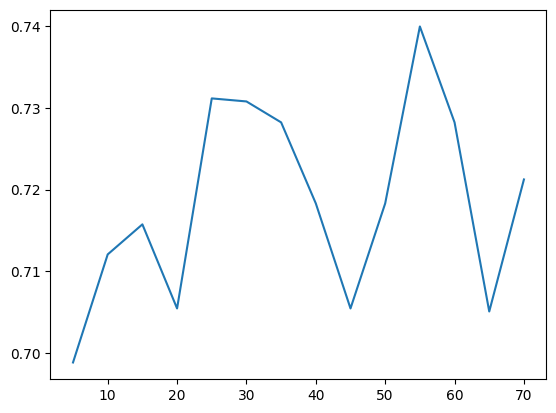

In [ ]:
auc_roc_arr = []
n_estimators_arr = [x * 5 for x in range(1,15)]
for n in n_estimators_arr:
  fit = RFC(n, max_depth = 10, min_samples_leaf = 1).fit(X_train, y_train)
  auc_roc_arr.append(roc_auc_score(y_test, fit.predict(X_test)))


plt.plot(n_estimators_arr, auc_roc_arr)

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
fir = RFC(40).fit(X_train, y_train)
importances = fir.feature_importances_

<BarContainer object of 8 artists>

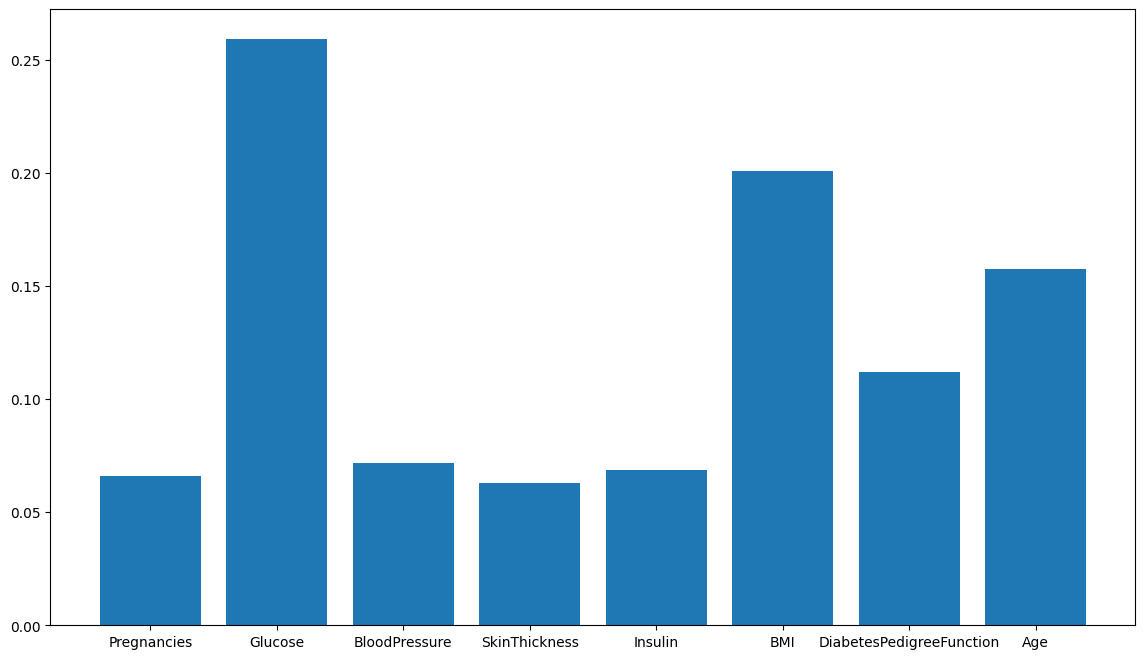

In [ ]:
plt.figure(figsize = (14,8))
plt.bar(X.columns, importances)